In [2]:
# importing required modules
import pandas as pd
import numpy as np
import copy
import time


In [3]:
""" ================= initialization setting ======================"""
"""Parallel"""
pt_tmp = pd.read_excel("fsp.xlsx", sheet_name="Parallel", index_col=[0])

dfshape = pt_tmp.shape  # (row, col)
num_mc = dfshape[1] - 1  # number of machines
num_job = dfshape[0] - 1  # 加入換線(setup time)


pt_tmp
dfshape
num_mc
# num_job


3

In [4]:
num_gene = num_mc * num_job  # number of genes in a chromosome

quantity = pt_tmp["Quantity"][:-1]

pt = [list(map(float, pt_tmp.iloc[i][:-1] * quantity[i]))
      for i in range(num_job)]
ct = list(map(float, pt_tmp.loc["ST"]))  # 換線時間
typeSequnce = list(pt_tmp.index[:-1])


population_size = int(
    input("Please input the size of population: ") or 30
)  # default value is 30 # 染色體數量
crossover_rate = float(
    input("Please input the size of Crossover Rate: ") or 0.8
)  # default value is 0.8 # 交配率
mutation_rate = float(
    input("Please input the size of Mutation Rate: ") or 0.2
)  # default value is 0.2 # 突變率：染色體要不要突變
mutation_selection_rate = float(
    input("Please input the mutation selection rate: ") or 0.2
)  # 突變選擇率：選幾個基因位置交換
num_mutation_jobs = round(
    num_gene * mutation_selection_rate)  # round四捨五入 2個基因要換
num_iteration = int(
    input("Please input number of iteration: ") or 30000
)  # default value is 30000 # 交配幾次, 迴圈幾遍
pt


[[20.0, 20.0, 10.0],
 [30.0, 30.0, 15.0],
 [45.0, 45.0, 22.5],
 [15.0, 15.0, 7.5],
 [80.0, 60.0, 40.0],
 [60.0, 45.0, 30.0],
 [40.0, 30.0, 20.0],
 [48.0, 36.0, 24.0],
 [112.0, 84.0, 56.0],
 [210.0, 140.0, 210.0],
 [36.0, 24.0, 36.0],
 [120.0, 80.0, 120.0]]

In [5]:
"""==================== main code ==============================="""

"""----- generate initial population -----"""
Tbest = 999999999999999
optimal_time = 0
population_list = []
makespan_record = []
for i in range(population_size):
    nxm_random_num = list(
        np.random.permutation(num_gene)
    )  # generate a random permutation of 0 to num_job*num_mc nxm:順序
    population_list.append(nxm_random_num)  # add to the population_list
    for j in range(num_gene):
        population_list[i][j] = (
            population_list[i][j] % num_job
        )  # convert to job number format, every job appears m (n*m) times, （m）機器的數量

start_time = time.time()
for n in range(num_iteration):
    Tbest_now = 99999999999

    """-------- two point crossover --------"""
    parent_list = copy.deepcopy(population_list)
    offspring_list = copy.deepcopy(population_list)
    S = list(
        np.random.permutation(population_size)
    )  # generate a random sequence to select the parent chromosome to crossover

    for m in range(int(population_size / 2)):
        crossover_prob = np.random.rand()  # 去生出一個機率
        if crossover_rate >= crossover_prob:  # 如果產出的機率在0-0.8之間就可以交配
            parent_1 = population_list[S[2 * m]][:]
            # 都是拿經過Ｓ對應的兩條（隔壁）染色體出來後，選裡面所有基因
            parent_2 = population_list[S[2 * m + 1]][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            cutpoint = list(
                np.random.choice(num_gene, 2, replace=False)
            )  # 隨機取基因 不重複, 染色體切兩刀 -> 三段基因串
            cutpoint.sort()

            child_1[cutpoint[0] : cutpoint[1]] = parent_2[cutpoint[0] : cutpoint[1]]
            child_2[cutpoint[0] : cutpoint[1]] = parent_1[
                cutpoint[0] : cutpoint[1]
            ]  # 兩刀中間段交換
            offspring_list[S[2 * m]] = child_1[:]
            offspring_list[S[2 * m + 1]] = child_2[:]

    """----------repairment-------------"""  # 若交換出現每條染色體裡的基因工作數量超過或太少，就必須修復
    for m in range(population_size):
        job_count = (
            {}
        )  # 字典 {name:value} {'A':2, 'B':3, 'C':4, 'D':2} job_count["A"] -> 3 or 集合 {value} [2, 3, 4, 2] -> {2, 3, 4}
        larger, less = (
            [],
            [],
        )  # 'larger' record jobs appear in the chromosome (染色體) more than m times, and 'less' records less than m times.
        for i in range(num_job):  # loop num_jop 有三個jop
            if i in offspring_list[m]:
                count = offspring_list[m].count(i)
                pos = offspring_list[m].index(i)
                job_count[i] = [
                    count,
                    pos,
                ]  # store the above two values to the job_count dictionary
            else:
                count = 0
                job_count[i] = [count, 0]
            if count > num_mc:
                larger.append(i)
            elif count < num_mc:
                less.append(i)

        for k in range(len(larger)):
            chg_job = larger[k]
            while job_count[chg_job][0] > num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0] < num_mc:
                        offspring_list[m][job_count[chg_job][1]] = less[d]
                        job_count[chg_job][1] = offspring_list[m].index(chg_job)
                        job_count[chg_job][0] = job_count[chg_job][0] - 1
                        job_count[less[d]][0] = job_count[less[d]][0] + 1
                    if job_count[chg_job][0] == num_mc:
                        break

    """--------mutatuon--------"""
    for m in range(len(offspring_list)):
        mutation_prob = np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg = list(
                np.random.choice(num_gene, num_mutation_jobs, replace=False)
            )  # chooses the position to mutation
            t_value_last = offspring_list[m][
                m_chg[0]
            ]  # save the value which is on the first mutation position
            for i in range(num_mutation_jobs - 1):
                offspring_list[m][m_chg[i]] = offspring_list[m][
                    m_chg[i + 1]
                ]  # displacement

            offspring_list[m][
                m_chg[num_mutation_jobs - 1]
            ] = t_value_last  # move the value of the first mutation position to the last mutation position

    """--------fitness value(calculate makespan)-------------"""
    # parent and offspring chromosomes combination
    total_chromosome = copy.deepcopy(parent_list) + copy.deepcopy(offspring_list)
    chrom_fitness, chrom_fit = [], []
    total_fitness = 0
    m_index = 0

    for chrom in total_chromosome:
        mc_dic = {}
        chrom_copy = copy.deepcopy(chrom)
        for m in range(num_mc):
            job_list = []
            job_seq = [i for i in range(num_job)]
            i = 0
            while job_seq:
                if chrom_copy[i] in job_seq:
                    job_seq.remove(chrom_copy[i])
                    job_list.append(chrom_copy.pop(chrom_copy.index(chrom_copy[i])))
                else:
                    i += 1
            mc_dic[m] = job_list

        jobs_type = copy.deepcopy(typeSequnce)
        jobs_time = {k: 0 for k in range(num_job)}
        for i in range(num_mc):
            change_index = 0
            pre_job = 0
            for j in mc_dic[i]:
                # 如果 前一機器作業時間 大於 當前機器前一份工件的作業時間再加換線時間，
                # 延續 前一機器作業時間
                if jobs_time[j] >= jobs_time[pre_job] + ct[i]:
                    jobs_time[j] += pt[j][i]
                # 當前機器前一份工件 + 當前工件，並確保job - job之間會有換線時間
                elif 0 < change_index < num_job:
                    if jobs_type[j] == jobs_type[pre_job]:
                        jobs_time[j] = jobs_time[pre_job] + pt[j][i]
                    else:
                        jobs_time[j] = jobs_time[pre_job] + ct[i] + pt[j][i]
                # 不滿足前兩項，則前一機器作業時間直接加上當前機器作業時間
                else:
                    jobs_time[j] += pt[j][i]
                change_index += 1
                pre_job = j

        makespan = max(jobs_time.values())
        chrom_fitness.append(1 / makespan)
        chrom_fit.append(makespan)
        total_fitness = total_fitness + chrom_fitness[m_index]
        m_index += 1

    """----------selection(roulette wheel approach)----------"""
    pk, qk = [], []

    for i in range(population_size * 2):
        pk.append(chrom_fitness[i] / total_fitness)
    for i in range(population_size * 2):
        cumulative = 0
        for j in range(0, i + 1):
            cumulative = cumulative + pk[j]
        qk.append(cumulative)

    selection_rand = [np.random.rand() for i in range(population_size)]

    for i in range(population_size):
        if selection_rand[i] <= qk[0]:
            population_list[i] = copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0, population_size * 2 - 1):
                if selection_rand[i] > qk[j] and selection_rand[i] <= qk[j + 1]:
                    population_list[i] = copy.deepcopy(total_chromosome[j + 1])
                    break

    """----------comparison----------"""
    for i in range(population_size * 2):
        if chrom_fit[i] < Tbest_now:
            Tbest_now = chrom_fit[i]
            sequence_now = copy.deepcopy(total_chromosome[i])
    if Tbest_now < Tbest:
        Tbest = Tbest_now
        sequence_best = copy.deepcopy(sequence_now)
        optimal_time = time.time() - start_time

    makespan_record.append(Tbest)

    """----------iteration stop(by optimal time ratio)----------"""
    optimal_time_ratio = optimal_time / (time.time() - start_time)
    if n >= 5000 and optimal_time_ratio < 0.5:
        break

optimal sequence [9, 11, 5, 9, 9, 3, 6, 1, 3, 11, 10, 7, 5, 0, 10, 5, 11, 7, 1, 7, 8, 6, 0, 10, 0, 8, 4, 4, 2, 2, 1, 6, 8, 3, 4, 2]
optimal value:950.000000
the total time:13.515524864196777
the optimal time:9.836479663848877
the optimal time ratio:0.7425969811679788


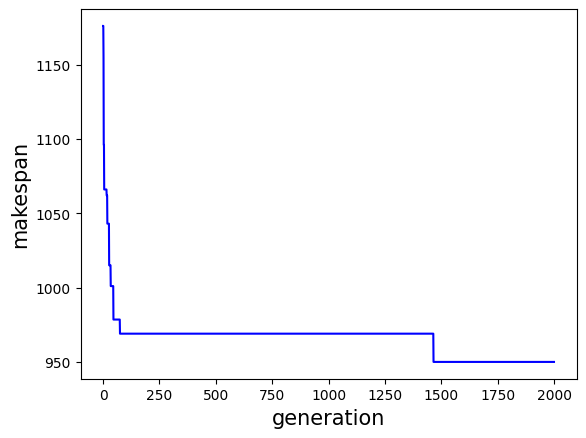

In [6]:
"""----------result----------"""
import matplotlib.pyplot as plt

print("optimal sequence", sequence_best)
print("optimal value:%f" % Tbest)
print("the total time:%s" % (time.time() - start_time))
print("the optimal time:%s" % optimal_time)
print("the optimal time ratio:%s" % optimal_time_ratio)


plt.plot([i for i in range(len(makespan_record))], makespan_record, "b")
plt.ylabel("makespan", fontsize=15)
plt.xlabel("generation", fontsize=15)
plt.show()


In [7]:
#'''--------plot gantt chart-------'''
import pandas as pd
import chart_studio as cs
import chart_studio.plotly as py

import plotly.figure_factory as ff
from plotly.offline import plot
import datetime

cs.tools.set_credentials_file(username="lzydaphne", api_key="qNPeqL1u0sKTBgGPjrmB")
m_keys = ["Machine %s" % (j + 1) for j in range(num_mc)]
j_keys = [j for j in range(num_job)]
j_count = {key: 0 for key in j_keys}
m_count = {key: 0 for key in m_keys}
j_record = {}
for i in sequence_best:
    for j in range(num_mc):
        gen_t = int(pt[i][j])
        j_count[i] +=  gen_t
        m_count[m_keys[j]] += + gen_t

        if m_count[m_keys[j]] < j_count[i]:
            m_count[m_keys[j]] = j_count[i]
        elif m_count[m_keys[j]] > j_count[i]:
            j_count[i] = m_count[m_keys[j]]
        start_time = str(
            datetime.timedelta(seconds=j_count[i] - pt[i][j])
        )  # convert seconds to hours, minutes and seconds

        end_time = str(datetime.timedelta(seconds=j_count[i]))
        j_record[(i, m_keys[j])] = [start_time, end_time]


df = []
for m in m_keys:
    for j in j_keys:
        df.append(
            dict(
                Task=m,
                Start="2018-06-24 %s" % (str(j_record[(j, m)][0])),
                Finish="2018-06-24 %s" % (str(j_record[(j, m)][1])),
                Resource="%s" % (j),
            )
        )
colors = {}
for i in j_keys:
    colors[str(i)] = "rgb(%s,%s,%s)" % (
        255 / (i + 1),
        (25 + 25 * i) % 256,
        (50 + 20 * i) % 256,
    )
# 9x5 flow shop problem

#    colors[str(i)]='rgb(%s,%s,%s)'%(255/(i+1),5+12*i,100/(i+1)) ## 20x5 flow shop problem

fig = ff.create_gantt(
    df,
    colors=colors,
    index_col="Resource",
    show_colorbar=True,
    group_tasks=True,
    showgrid_x=True,
)
py.iplot(fig, filename="APS", world_readable=True)  # 9x5 flow shop problem